In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import imp
import sys
sys.path.insert(0,'/home/robin/Projects/sciunit')
sys.path.insert(0,'/home/robin/Projects/INM6/elephant')
sys.path.append('/home/robin/Projects/INM6/python-neo')
# sys.path.append('/home/robin/Projects/simrest_validation')
sys.path.append('/home/robin/Projects/NetworkUnit')
sys.path.append('/home/robin/Projects/INM6/Tasks/')
import sciunit
from viziphant.plots.rasterplot import rasterplot
from elephant.spike_train_surrogates import * 
from elephant.statistics import mean_firing_rate, cv, isi
from validation.matrix import eigenvalue_significance, plot_EVs
from validation.matrix import corr_matrix, plot_matrix, reorder_matrix
from scipy.linalg import eigh
from networkunit import models, tests, scores
from networkunit.plots import alpha
from networkunit.scores import to_precision
import seaborn as sns
from quantities import Hz, ms
from scipy.linalg import eigh
from IPython.core.display import HTML
import urllib2
from time import time
# HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())
rc('text', usetex=True)
font_size = 24
text_size = 26

## Test Network

In [7]:
size = 100
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms

model_HPP = models.stochastic_activity(size=size, correlations=0, assembly_sizes=[],
                                correlation_method='HPP', t_start=tstart, t_stop=tstop,
                                shuffle=False, name='A', color=sns.color_palette('Set2')[2])

## Eigenvalue analysis

In [8]:
cc_matrix = corr_matrix(model_HPP.spiketrains)
EWs, EVs = eigh(cc_matrix)

1.29050538053

Significance Test:
	Method: SCREE 
	3 of 100 eigenvalues are significant

Princial components:
	0: 1.29
	1: 1.27
	2: 1.25



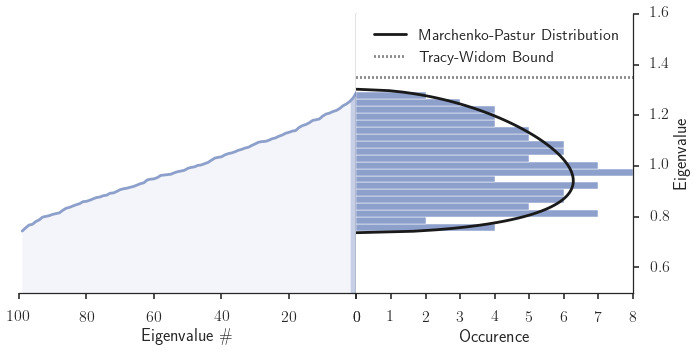

In [9]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11,5))

print max(EWs)

eigenvalue_significance(EWs, ax=ax, bins=20, N=size, 
                        B=float((tstop-tstart)/binsize),
                        ylim=(.5, 1.6),
                        color=sns.color_palette('Set2')[2]);

ax.set_xlabel('Eigenvalue \#')

plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/ew_dist_hpp.pdf', bbox_inches='tight')

## Spectral Norm

In [71]:
from scipy.stats import zscore

trial_num = 1
l_max = np.zeros(trial_num)

for t in range(trial_num):
#     model_HPP = models.stochastic_activity(size=100, correlations=0, assembly_sizes=[],
#                                     correlation_method='HPP', t_start=tstart, t_stop=tstop, rate=10*Hz,
#                                     shuffle=False, name='A', color=sns.color_palette('Set2')[2])

#     cc_matrix = corr_matrix(model_HPP.spiketrains)
    r_mat = np.random.randint(0,2,(100,100))
    for i in range(100):
        r_mat[i] = zscore(r_mat[i]) 
#     r_mat[i] /= np.linalg.norm(r_mat[i])
    cc_matrix = np.dot(r_mat,r_mat.T) / 100.
    np.fill_diagonal(cc_matrix, 1)
    EWs, EVs = eigh(cc_matrix)
    l_max[t] = max(EWs)
    print cc_matrix.shape
    print cc_matrix

(100, 100)
[[ 1.   -0.25 -0.25 ..., -0.17  0.19  0.02]
 [-0.25  1.    0.19 ...,  0.19 -0.19  0.12]
 [-0.25  0.19  1.   ...,  0.19 -0.16 -0.02]
 ..., 
 [-0.17  0.19  0.19 ...,  1.   -0.17 -0.03]
 [ 0.19 -0.19 -0.16 ..., -0.17  1.    0.04]
 [ 0.02  0.12 -0.02 ..., -0.03  0.04  1.  ]]


In [72]:
print max(l_max), min(l_max)
print np.mean(l_max)

19.0420566268 19.0420566268
19.0420566268


## Eigenvectors


In [18]:
from neo.core import SpikeTrain
size = 100
A = 5
cc = .2
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms

model_cpp = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=[A],
                                correlation_method='CPP', t_start=tstart, t_stop=tstop,
                                shuffle=False)

# test_st = SpikeTrain(np.array(model_cpp.spiketrains[0].tolist())+2, units='ms', 
#                      t_start=tstart, t_stop=tstop)
# model_cpp.spiketrains = model_cpp.spiketrains + [test_st]

In [19]:
cc_matrix = corr_matrix(model_cpp.spiketrains)
EWs, EVs = eigh(cc_matrix)

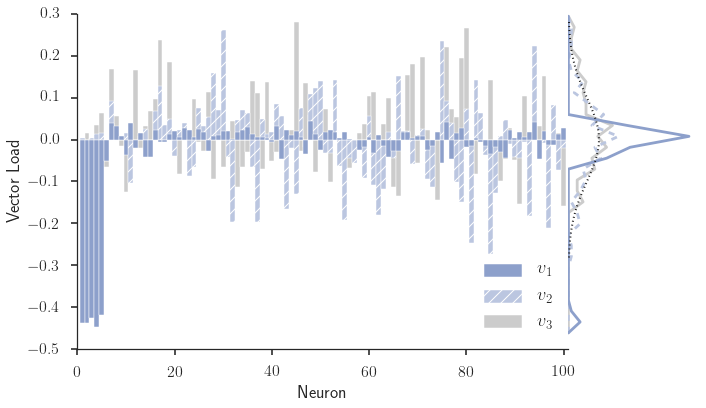

In [21]:
from matplotlib import rc
rc('text', usetex=True)
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11,6), sharex=True)
palette = sns.color_palette('Set2')

plot_EVs(EVs, ax, [palette[2], alpha(palette[2],0.6), '0.8'], ['', '//', ''], scaling=.8)

plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/ev_loads.pdf')

## Assembly reconstruction

In [51]:
size = 100
A = [10,5,5]
cc = [.4,.3,.2]
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms

model_cpp = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                correlation_method='CPP', t_start=tstart, t_stop=tstop,
                                shuffle=True)

In [52]:
cpp_mat = corr_matrix(model_cpp.spiketrains, binsize=binsize)

EWs, EVs = eigh(cpp_mat)
order = reorder_matrix(EVs, EWs, alpha=0.001)

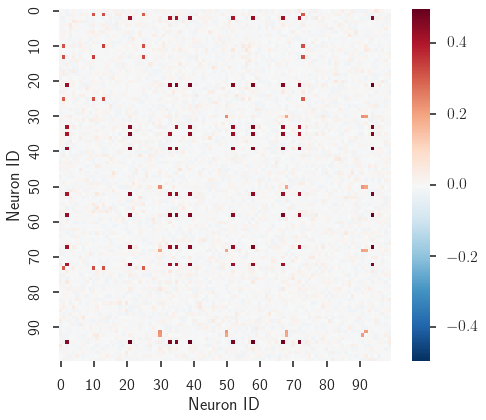

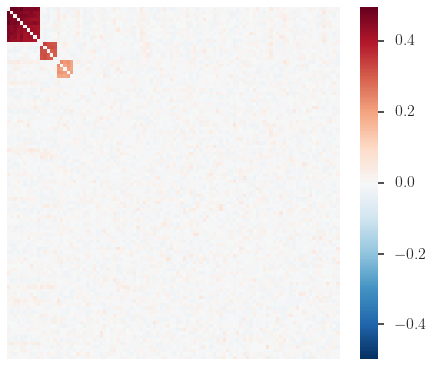

In [53]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,6))
fig.tight_layout()

plot_matrix(cpp_mat, ax=ax, remove_autocorr=True)
ax.set_ylabel('Neuron ID')
ax.set_xlabel('Neuron ID')
plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/ordered_ccmatrix_pre.pdf')

sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,6))
fig.tight_layout()

plot_matrix(cpp_mat[order,:][:,order], ax=ax, remove_autocorr=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/ordered_ccmatrix_post.pdf')

## Angles

In [71]:
size = 100
A = []
cc = .0
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms

model_A = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                correlation_method='CPP', t_start=tstart, t_stop=tstop,
                                shuffle=False)
model_B = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                correlation_method='CPP', t_start=tstart, t_stop=tstop,
                                shuffle=False)

In [75]:
matA = corr_matrix(model_A.spiketrains, binsize=binsize)
matB = corr_matrix(model_B.spiketrains, binsize=binsize)

_, EVs_A = eigh(matA)
_, EVs_B = eigh(matB)

EVs_A = EVs_A.T[::-1]
EVs_B = EVs_B.T[::-1]

flip = False

if flip:
    for count, ev in enumerate(EVs_A):
        EVs_A[count] = ev * np.sign(ev[np.argmax(np.absolute(ev))])
    for count, ev in enumerate(EVs_B):
        EVs_B[count] = ev * np.sign(ev[np.argmax(np.absolute(ev))])
    
M = np.dot(EVs_A, EVs_B.T)
ev_angles = [np.arccos(M.flatten())]
# ev_angles = [np.arccos(np.diag(M))]

In [76]:
res = 10000
angles = np.linspace(0,np.pi,res)
dist = np.array([np.sin(a)**(size-2) for a in angles])
dist = dist / (np.sum(dist) * np.pi/res)

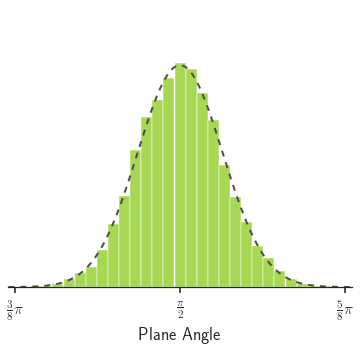

In [77]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
plt.tight_layout()

ax.plot(angles, dist, color='0.3', lw=2, ls='--', label=r'$\sin^{}\phi$'.format('{'+str(size-2)+'}'))

edges = np.linspace(0,np.pi,120)
hist, _ = np.histogram(ev_angles, bins=edges, density=True)
# hist_diag, _ = np.histogram(ev_angles_diag, bins=edges, density=True)

ax.bar(edges[:-1], hist, np.diff(edges)[0]*.99, color=sns.color_palette()[4], edgecolor='w', 
       label=r'$\angle (\mathbf{v}_i,\mathbf{w}_j)$' + r'$: \mathrm{v},\mathrm{w}\in R^{100}$')
# ax.bar(edges[:-1], hist_diag, np.diff(edges)*.9, color=sns.color_palette()[4], edgecolor='w')


ax.set_xticks(np.array([0, 0.125, .25, .375, .5, .625, .75, .875, 1])*np.pi)
ax.set_xticklabels(['', r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$',
                    r'$\frac{3}{8}\pi$', r'$\frac{\pi}{2}$',
                    r'$\frac{5}{8}\pi$', r'$\frac{3}{4}\pi$',
                    r'$\frac{7}{8}\pi$', r'$\pi$'])
ax.set_xlabel(r'Plane Angle')
sns.despine()
if flip:
    ax.yaxis.set_ticklabels([])
    ax.yaxis.set_ticks([])
    sns.despine(left=True)

ax.set_ylim((0,5))
frame = np.pi*0.13
ax.set_xlim((np.pi/2.-frame, np.pi/2.+frame))
if flip:
    plt.legend()

sns.despine(left=True)
ax.set_yticks([])
ax.set_yticklabels([''])

plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/random_angle_distribution{}.pdf'\
            .format('_flipped' if flip else ''), bbox_inches='tight')

## Angles as distance measure

In [86]:
size = 100
A = [10,5,5]
cc = [.4,.3,.2]
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms

model_A = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                correlation_method='CPP', t_start=tstart, t_stop=tstop,
                                shuffle=False)
model_B = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                correlation_method='CPP', t_start=tstart, t_stop=tstop,
                                shuffle=False)


In [87]:
matA = corr_matrix(model_A.spiketrains, binsize=binsize)
matB = corr_matrix(model_B.spiketrains, binsize=binsize)

_, EVs_A = eigh(matA)
_, EVs_B = eigh(matB)

EVs_A = EVs_A.T[::-1]
EVs_B = EVs_B.T[::-1]

for count, ev in enumerate(EVs_A):
    EVs_A[count] = ev * np.sign(ev[np.argmax(np.absolute(ev))])
for count, ev in enumerate(EVs_B):
    EVs_B[count] = ev * np.sign(ev[np.argmax(np.absolute(ev))])
    
M = np.dot(EVs_A, EVs_B.T)
ev_angles = [np.arccos(M.flatten())]
# ev_angles = [np.arccos(np.diag(M))]

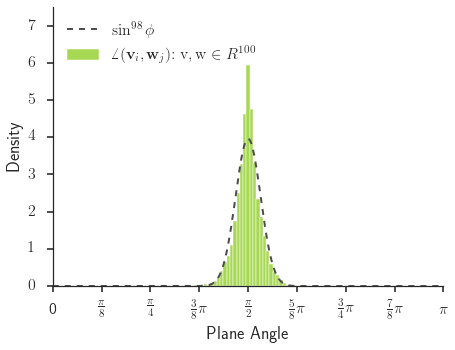

In [92]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

ax.plot(angles, dist, color='0.3', lw=2, ls='--', label=r'$\sin^{}\phi$'.format('{'+str(size-2)+'}'))

edges = np.linspace(0,np.pi,120)
hist, _ = np.histogram(ev_angles, bins=edges, density=True)
# hist_diag, _ = np.histogram(ev_angles_diag, bins=edges, densit=True)

ax.bar(edges[:-1], hist, np.diff(edges)*.99, color=sns.color_palette()[4], edgecolor='w', 
       label=r'$\angle (\mathbf{v}_i,\mathbf{w}_j)$' + r'$: \mathrm{v},\mathrm{w}\in R^{100}$')
# ax.bar(edges[:-1], hist_diag, np.diff(edges)*.9, color=sns.color_palette()[4], edgecolor='w')


ax.set_xticks(np.array([0, 0.125, .25, .375, .5, .625, .75, .875, 1])*np.pi)
ax.set_xticklabels(['0', r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$',
                    r'$\frac{3}{8}\pi$', r'$\frac{\pi}{2}$',
                    r'$\frac{5}{8}\pi$', r'$\frac{3}{4}\pi$',
                    r'$\frac{7}{8}\pi$', r'$\pi$'])
ax.set_xlabel(r'Plane Angle')
sns.despine()
ax.set_xlim((0,np.pi))
frame = np.pi*0.13
# ax.set_xlim((np.pi/2.-frame, np.pi/2.+frame))
log = False
if log:
    ax.set_yscale('log')
    ax.set_ylim((0.001, np.max(hist)))
else:
    ax.set_ylabel('Density', fontweight='bold')
    plt.legend(loc=2)
    ax.set_ylim((0,7.5))

plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/cluster_angle_distribution{}.pdf'\
            .format('_log' if log else ''), bbox_inches='tight')

### Weighted Angle Dist

In [130]:
class angle_test(sciunit.TestM2M, tests.correlation_matrix_test):
    score_type = scores.weighted_angle
    params = {'all_to_all': False,
              'two_sided': False,
              'alpha': 0.0001}

    def compute_score(self, prediction1, prediction2):
        score = self.score_type.compute(prediction1, prediction2, **self.params)
        return score

angles = np.array([])

size = 100
A = []
cc = .0
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms
B = int(tstop/binsize)

all_to_all = True

In [131]:
sample_angles = np.array([])
wmean_angles = np.array([])
start_time = time()

for i in range(1000):
    model_A = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                    correlation_method='HPP', t_start=tstart, t_stop=tstop,
                                    shuffle=False, name='modelA')
    model_B = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                    correlation_method='HPP', t_start=tstart, t_stop=tstop,
                                    shuffle=False, name='modelB')

    a_test = angle_test()
    EWsA, EVsA = eigh(a_test.generate_prediction(model_A))
    EWsB, EVsB = eigh(a_test.generate_prediction(model_B))
    EWsA = EWsA[::-1]
    EWsB = EWsB[::-1]
    EVsA = EVsA.T[::-1]
    EVsB = EVsB.T[::-1]
    for count, ev in enumerate(EVsA):
        EVsA[count] = ev * np.sign(ev[np.argmax(np.absolute(ev))])
    for count, ev in enumerate(EVsB):
        EVsB[count] = ev * np.sign(ev[np.argmax(np.absolute(ev))])
    M = np.dot(EVsA, EVsB.T)
    M[np.argwhere(M > 1)] = 1.
    if all_to_all:
        angles = np.arccos(M.flatten())
        weights = np.zeros((len(EWsA),len(EWsA)))
        for count1, ew1 in enumerate(EWsA):
            for count2, ew2 in enumerate(EWsB):
                weights[count1,count2] = np.sqrt((ew1**2 + ew2**2)/2.)
        weights = weights.flatten()
        angle_nbr = size**2
    else:
        angles = np.arccos(np.diag(M))
        weights = np.sqrt((EWsA ** 2 + EWsB ** 2) / 2.)
        angle_nbr = size
    weights = weights / sum(weights)
    sample_angles = np.append(sample_angles, angles*weights*angle_nbr)
    wmean_angles = np.append(wmean_angles, np.mean(angles*weights*angle_nbr))
                            
m, s = divmod(time() - start_time, 60)
h, m = divmod(m, 60)
print 'Computation took %d:%02d:%02d' % (h, m, s)

Computation took 1:29:23


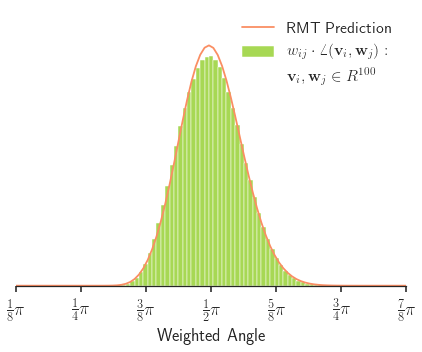

In [132]:
from matplotlib import mlab
sns.set(context='poster', style='ticks', palette='Set2')
fig, ax = plt.subplots(figsize=(7,5))

ax.set_xticks(np.array([0, 0.125, .25, .375, .5, .625, .75, .875, 1]) * np.pi)
ax.set_xticklabels(['0', r'$\frac{1}{8}\pi$', r'$\frac{1}{4}\pi$',
                    r'$\frac{3}{8}\pi$', r'$\frac{1}{2}\pi$',
                    r'$\frac{5}{8}\pi$', r'$\frac{3}{4}\pi$',
                    r'$\frac{7}{8}\pi$', r'$\pi$'], fontsize=18)

ax.set_xlabel(r'Weighted Angle$')
#               + r'$^{}$'.format('{' + str(size) + '}'), fontsize=20)

edges = np.linspace(0, np.pi, 120)
hist, _ = np.histogram(sample_angles/sum(weights), bins=edges, density=True)
# 120
# hist_o2o=[0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.00113636629368,  0.00113636629368,  0.0143939730532,  0.0212121708153,  0.0409091865723,  0.0996214450789,  0.164015535054,  0.254924838548,  0.37310693309,  0.551137652433,  0.708713778489,  0.890911174242,  1.01477510025,  1.11666927792,  1.24091199269,  1.29469999726,  1.34545769171,  1.38901839964,  1.38560930076,  1.37462442658,  1.43863972779,  1.42121544462,  1.41780634574,  1.41363966933,  1.38826082211,  1.41363966933,  1.34091222654,  1.31515459055,  1.24356351405,  1.27121509386,  1.20795737018,  1.14129054762,  1.10076014981,  1.03636605983,  0.937123403518,  0.860608073077,  0.792047306692,  0.705683468373,  0.621971151405,  0.543561877142,  0.447728319708,  0.371591778032,  0.303788589176,  0.246591485728,  0.175379197991,  0.146591251884,  0.105303276547,  0.0613637798585,  0.0473485955698,  0.0344697775748,  0.0170454944051,  0.0132576067596,  0.0064394089975,  0.00227273258735,  0.00303031011647,  0.000757577529117,  0.000378788764559,  0.000378788764559,  0.0,  0.000378788764559,  0.0,  0.0,  0.0,  0.000378788764559,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0]
# hist_a2a=[0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  3.78788764559e-06,  1.51515505823e-05,  5.30304270382e-05,  0.000174242831697,  0.000522728495091,  0.00140530631651,  0.00368561467916,  0.00883714187715,  0.0199924709934,  0.0390379700754,  0.0721175928843,  0.12344725837,  0.195701215209,  0.295455236356,  0.418811585422,  0.559997521636,  0.721759263541,  0.900206650524,  1.07666539649,  1.25643475627,  1.43015107158,  1.58951508061,  1.73638284829,  1.85612176465,  1.95445532793,  2.02048199748,  2.06311467293,  2.05576238301,  2.01677744336,  1.96292125682,  1.85725055517,  1.7353070882,  1.59599994425,  1.43687457215,  1.27440070737,  1.10537000907,  0.942759780335,  0.787047295,  0.652732586975,  0.525936835927,  0.415883548272,  0.324417425294,  0.247235426627,  0.184159521553,  0.134682133126,  0.0934812792054,  0.0656213655722,  0.0440796485317,  0.0288409765335,  0.018928074565,  0.0118485125554,  0.00673486423385,  0.00422728261248,  0.00237500555378,  0.00126894236127,  0.00071212287737,  0.000359849326331,  0.000208333820507,  6.4394089975e-05,  3.78788764559e-05,  2.27273258735e-05,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0]
if all_to_all:
    label = [r'$w_{ij}\cdot\angle (\mathbf{v}_i,\mathbf{w}_j):$', '$\mathbf{v}_i,\mathbf{w}_j \in R^{100}$']
else:
    label = [r'$w_{ii}\cdot\angle (\mathbf{v}_i,\mathbf{w}_i):$', '$\mathbf{v}_i,\mathbf{w}_i \in R^{100}$']
ax.bar(edges[:-1], hist, np.diff(edges)[0] * .99,
       color=sns.color_palette('Set2')[4], edgecolor='w',
       label='{}'.format(label[0]))
ax.bar([.1,.1],[0.1,0.1], color='w', edgecolor='w', 
       label='{}'.format(label[1]))

x = np.linspace(0, np.pi, 120)
y = scores.weighted_angle.weighted_angle_distribution(x, size, B=5000, use_gaus=all_to_all)
norm = np.sum(y) * (x[1] - x[0])
ax.plot(x, np.array(y) / norm, color=sns.color_palette('Set2')[1], label='RMT Prediction', lw=1.8)
ax.set_xlim((0.125*np.pi,0.875*np.pi))
ax.set_yticks([])
plt.legend()

sns.despine(left=True)
plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/weighted_angle_distribution{}.pdf'
            .format('_all_to_all' if all_to_all else ''), 
            bbox_inches='tight')

plt.show()

In [122]:
a = ['{}, '.format(h) for h in hist]
for i in a:
    print i,

0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  3.78788764559e-06,  1.51515505823e-05,  5.30304270382e-05,  0.000174242831697,  0.000522728495091,  0.00140530631651,  0.00368561467916,  0.00883714187715,  0.0199924709934,  0.0390379700754,  0.0721175928843,  0.12344725837,  0.195701215209,  0.295455236356,  0.418811585422,  0.559997521636,  0.721759263541,  0.900206650524,  1.07666539649,  1.25643475627,  1.43015107158,  1.58951508061,  1.73638284829,  1.85612176465,  1.95445532793,  2.02048199748,  2.06311467293,  2.05576238301,  2.01677744336,  1.96292125682,  1.85725055517,  1.7353070882,  1.59599994425,  1.43687457215,  1.27440070737,  1.10537000907,  0.942759780335,  0.787047295,  0.652732586975,  0.525936835927,  0.415883548272,  0.324417425294,  0.247235426627,  0.184159521553,  0.134682133126,  0.0934812792054,  0.0656213655722,  0.0440

In [123]:
import scipy.interpolate as interpolate

x = np.linspace(0, np.pi, 120)
y = scores.weighted_angle.weighted_angle_distribution(x, size, B=5000, use_gaus=all_to_all)
norm = np.sum(y) * (x[1] - x[0])
y = y / norm

def inverse_transform_sampling(x, y, n_samples=1000):
    x = x + np.diff(x)[0]/2.
    x = np.append(np.array([0]),x)
    cum_values = np.zeros(len(x))
    cum_values[1:] = np.cumsum(y*np.diff(x))
    inv_cdf = interpolate.interp1d(cum_values, x)
    r = np.random.rand(n_samples)
    return inv_cdf(r)

sample_std = np.std(inverse_transform_sampling(x,y,n_samples=10**6))
print sample_std
print np.std(sample_angles)

0.18394648163
0.185808615589


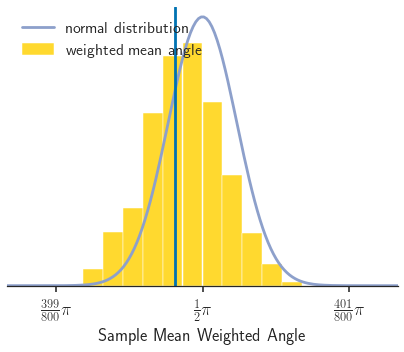

In [148]:
import matplotlib.mlab as mlab
sns.set(context='poster', style='ticks', palette='Set2')
fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel(r'Sample Mean Weighted Angle')
#               + r'$^{}$'.format('{' + str(size) + '}'), fontsize=20)

if all_to_all:
    edges = np.linspace(np.pi/2.-np.pi/200., np.pi/2.+np.pi/200., 60)
else:
    edges = np.linspace(np.pi/2.-np.pi/20., np.pi/2.+np.pi/20., 60)
    
hist, _ = np.histogram(wmean_angles, bins=edges, density=True)
# wmeans_o2o=[1.57497398111,  1.56578293938,  1.55481030708,  1.57848773038,  1.56859999928,  1.5898152644,  1.56811539284,  1.55988533857,  1.57605880288,  1.58053906913,  1.56851962574,  1.572541528,  1.5728221041,  1.56032621636,  1.56315909565,  1.57469724589,  1.58395796048,  1.5514855108,  1.570096653,  1.56879908059,  1.57432190817,  1.54536151561,  1.58219107706,  1.54751346381,  1.56950937862,  1.56692778348,  1.5738144853,  1.58110869183,  1.55275004016,  1.56714382296,  1.56398633447,  1.56698190727,  1.56989374115,  1.58253063763,  1.57850610707,  1.56263825849,  1.56642960655,  1.57524421441,  1.59161324348,  1.58501199844,  1.58462141126,  1.56802705966,  1.55573345958,  1.56090770391,  1.56776792794,  1.57761132229,  1.56556936405,  1.5837323362,  1.58135146069,  1.57842480398,  1.55884643317,  1.57677890381,  1.5802160849,  1.57267947331,  1.57248546359,  1.57933616228,  1.57190514357,  1.56494460868,  1.5920544648,  1.58989780202,  1.56761469973,  1.56767601525,  1.57835873621,  1.57018569793,  1.57034764105,  1.57170817188,  1.57854286123,  1.57466101687,  1.59398583184,  1.56439119589,  1.57517911224,  1.58202497972,  1.55628444663,  1.57815148381,  1.55563262649,  1.55503076073,  1.57166705088,  1.55180718891,  1.56652090187,  1.57230730075,  1.57389933908,  1.56925582939,  1.5650577327,  1.57001747164,  1.57538233654,  1.58138750892,  1.56397933851,  1.57216590726,  1.57866295107,  1.56631113494,  1.57615567881,  1.56784925556,  1.57992363019,  1.55065868616,  1.57225749059,  1.56186810772,  1.55585614592,  1.57036051228,  1.55287625698,  1.57094751817,  1.56551709753,  1.57761603307,  1.56921605847,  1.57742281135,  1.55476791286,  1.57610163867,  1.57218768663,  1.57278293004,  1.57556293417,  1.56725395739,  1.56416332126,  1.5767601533,  1.55269228826,  1.5733510814,  1.57991262878,  1.56441595567,  1.57605125476,  1.58260535901,  1.56874570678,  1.57768771548,  1.56065471703,  1.5668966793,  1.58671433419,  1.57238877944,  1.57828299629,  1.58514826273,  1.56362524541,  1.56545611942,  1.56775553296,  1.57914083521,  1.56499302241,  1.58517512884,  1.56185672934,  1.56719686371,  1.55001496687,  1.57295151514,  1.57203720979,  1.58347915564,  1.57411220717,  1.5798889927,  1.56798727957,  1.57207573833,  1.57433250911,  1.57725341651,  1.56548790057,  1.58019340322,  1.58615314659,  1.57918908354,  1.5527216085,  1.55925424564,  1.57977255923,  1.57706966655,  1.58416303341,  1.56712021384,  1.55968236551,  1.56550791882,  1.56237883745,  1.57315265564,  1.57724126912,  1.55117772075,  1.56008544727,  1.56335826099,  1.57094342287,  1.56404405311,  1.55688222034,  1.57726170388,  1.57253162506,  1.56859075938,  1.546296274,  1.5788136593,  1.57503980371,  1.56520625878,  1.59279540195,  1.57754240698,  1.58777134776,  1.55600046251,  1.56710729104,  1.59117071578,  1.57450860067,  1.58241175877,  1.5695167141,  1.56421938056,  1.56409593452,  1.56053136711,  1.55295248357,  1.57137004065,  1.58555570906,  1.56245060731,  1.57664544217,  1.55910402926,  1.57534706751,  1.58706178082,  1.55840311675,  1.56541546444,  1.56795968226,  1.56274307308,  1.56088480365,  1.56495006622,  1.55693239409,  1.57409763694,  1.56897832909,  1.57441527612,  1.57173140221,  1.55141582591,  1.56400946892,  1.57286191014,  1.57399954211,  1.58667102396,  1.55849897322,  1.59433574341,  1.57834815985,  1.5792520254,  1.56243994278,  1.57288140558,  1.56581640118,  1.58255399952,  1.57797374613,  1.56516492076,  1.56364650078,  1.58201770623,  1.59165582323,  1.55387488392,  1.57537729712,  1.57090076727,  1.57357890969,  1.55757032297,  1.55458321026,  1.57646892834,  1.56366553505,  1.58749731961,  1.56479212926,  1.53857275725,  1.57025308142,  1.57779670685,  1.57898434034,  1.56917145797,  1.57315706565,  1.57532206924,  1.56764850044,  1.57600258152,  1.56405508479,  1.5749405428,  1.55213037016,  1.58190554396,  1.58996200595,  1.58429347069,  1.5738091927,  1.56060583999,  1.56820385086,  1.56775682933,  1.56870164914,  1.58501211825,  1.59595806087,  1.56571196972,  1.56814675903,  1.56689504256,  1.56493954176,  1.57931601542,  1.57761165458,  1.56292881508,  1.58448777065,  1.58584661904,  1.56232134504,  1.58288437545,  1.5574624619,  1.56479205072,  1.56701478366,  1.54923413968,  1.56170677234,  1.57614428153,  1.57270760325,  1.56024528567,  1.56814947581,  1.56513543287,  1.56124185354,  1.58059583532,  1.56889545649,  1.57221529656,  1.55557959961,  1.58087596194,  1.57240892772,  1.57672918222,  1.56635895003,  1.56560872534,  1.59149644711,  1.56317303993,  1.55709299658,  1.56918799969,  1.56665826657,  1.58493080007,  1.55722362539,  1.57574583807,  1.56842659526,  1.57661568233,  1.55142022655,  1.56728902469,  1.58205553405,  1.57287380631,  1.56693075468,  1.56221099338,  1.57004007991,  1.55587491589,  1.57578657896,  1.56943292061,  1.57058020877,  1.58458461777,  1.57394316924,  1.588608804,  1.56297624572,  1.56670804632,  1.57688867157,  1.57566159844,  1.57413252263,  1.57611645903,  1.56742420647,  1.57479630672,  1.5944826875,  1.55225384832,  1.55276549395,  1.57733983947,  1.5631575176,  1.56481146498,  1.56458809626,  1.58880596725,  1.57627666106,  1.57764468758,  1.57246359065,  1.58079468326,  1.57300067223,  1.56186187301,  1.56470114131,  1.57595009119,  1.58378210368,  1.60207138364,  1.57215714967,  1.57341697614,  1.55545488124,  1.5730404662,  1.55147704425,  1.55671655761,  1.57460206247,  1.58050885691,  1.57378874856,  1.58061906397,  1.56268113809,  1.5651124241,  1.56422521316,  1.55963800423,  1.58820683042,  1.57730456261,  1.57963330523,  1.57773408531,  1.57580516085,  1.57710145978,  1.57600167193,  1.54751329639,  1.58226580432,  1.55488475035,  1.56142143098,  1.55917833017,  1.58244127007,  1.56695953496,  1.57606308866,  1.567997333,  1.56538092537,  1.56204560299,  1.572430978,  1.58549659151,  1.55816091874,  1.55973892216,  1.56365290682,  1.56220200691,  1.56858464669,  1.57694958119,  1.55525188474,  1.5748119672,  1.58072312754,  1.56194231772,  1.56243584526,  1.58091539786,  1.58552138818,  1.56938353371,  1.56009203261,  1.56978301125,  1.57700788931,  1.56163499646,  1.57530053778,  1.56742638026,  1.55597231712,  1.5672390276,  1.5771536409,  1.57694648975,  1.57782607842,  1.56483053096,  1.5765659915,  1.56904268212,  1.57605945452,  1.56818553537,  1.56132506709,  1.59281498623,  1.585052878,  1.56567389371,  1.55487033845,  1.55040750996,  1.57008711183,  1.56851220993,  1.57757270286,  1.56676490147,  1.57188634203,  1.56254611494,  1.57498228362,  1.55290013144,  1.57044194429,  1.57660446549,  1.57393589289,  1.55760700375,  1.57478266893,  1.5671827945,  1.5691328073,  1.56212318711,  1.56858933408,  1.5616027822,  1.58518730027,  1.56040878047,  1.57245892043,  1.56453227252,  1.56152855604,  1.56578977371,  1.56406818656,  1.57334898639,  1.57933105708,  1.57228777666,  1.56369219917,  1.56510964551,  1.57187587076,  1.58604404684,  1.59493192124,  1.5611697289,  1.58093520767,  1.56402068349,  1.56712557041,  1.58742594512,  1.5600357287,  1.56420343349,  1.55358578658,  1.57088871245,  1.57637494049,  1.56536311749,  1.54949468792,  1.56641027622,  1.54967087496,  1.56655592834,  1.59080833037,  1.56381583827,  1.57163101148,  1.55977755688,  1.53818060255,  1.57567934956,  1.58632744501,  1.57273179591,  1.56108142193,  1.58396908182,  1.56471957294,  1.58230505135,  1.57886598982,  1.56865776123,  1.58409081641,  1.5658525722,  1.57477868145,  1.56435964931,  1.58051371122,  1.57562724985,  1.57922655666,  1.55860116256,  1.57159458427,  1.5648376619,  1.55396093704,  1.55597348268,  1.57238829131,  1.55523136949,  1.56709057903,  1.57168913033,  1.57414742669,  1.56175592401,  1.57047511859,  1.59056934074,  1.5890036526,  1.56412187468,  1.57724783465,  1.57585198684,  1.57567147176,  1.57141187683,  1.5632480465,  1.55557024961,  1.56690310236,  1.57712081111,  1.5631479616,  1.58321951205,  1.5693643954,  1.58942791201,  1.57489565607,  1.5456206573,  1.57099972695,  1.57699271231,  1.59226160416,  1.57634944912,  1.57275742462,  1.5631225795,  1.55804512468,  1.57901213038,  1.56802949954,  1.56481851777,  1.57940741649,  1.5520186181,  1.58434072279,  1.56733877671,  1.57995535609,  1.56097570836,  1.58811361774,  1.57682660878,  1.54729914587,  1.5489709691,  1.55806850745,  1.55354920983,  1.5725697335,  1.56055059527,  1.56863626376,  1.56995837679,  1.55457921692,  1.55419517756,  1.57112465441,  1.55436892343,  1.56564149641,  1.56671375624,  1.58450315824,  1.55959995947,  1.58213319245,  1.57713696297,  1.57421805374,  1.56958228902,  1.58580872429,  1.57279924992,  1.56901624587,  1.5753631462,  1.57922092282,  1.57460633939,  1.59175358284,  1.59085805055,  1.57343512249,  1.55225312675,  1.55842001437,  1.57438419361,  1.57969438124,  1.57292884067,  1.58456331226,  1.56845330495,  1.57464771446,  1.56916977503,  1.56851187956,  1.57557751921,  1.57430217226,  1.5677593848,  1.57147884744,  1.56080165871,  1.57652156216,  1.54901783921,  1.56482287587,  1.56622033191,  1.56101025875,  1.55704807287,  1.56538631085,  1.56593423588,  1.56012176898,  1.58053619448,  1.57158743452,  1.56121301556,  1.54689884012,  1.56849714686,  1.57767653531,  1.56384756383,  1.56943309237,  1.5619058682,  1.58241558599,  1.55364005172,  1.56884269918,  1.5644967812,  1.55821975827,  1.55966869503,  1.56778199293,  1.58523392236,  1.57247408407,  1.55640757649,  1.57268151169,  1.56996031382,  1.55946289843,  1.57956347276,  1.59014828099,  1.56382295539,  1.56866745273,  1.58341784818,  1.56728431099,  1.56265792835,  1.56457020508,  1.56917873564,  1.55776893418,  1.55958925159,  1.56905850995,  1.56090186641,  1.55720656323,  1.57277208737,  1.55687173497,  1.55955827434,  1.56237015719,  1.57094306494,  1.56947699136,  1.57720183252,  1.5552120404,  1.57334206989,  1.57637651443,  1.5749832038,  1.57326962546,  1.55301977571,  1.57159324839,  1.57310582411,  1.57420725955,  1.56862542761,  1.56908310455,  1.56705483186,  1.56955742448,  1.57848435517,  1.57095804404,  1.56275558581,  1.56738709995,  1.58138780512,  1.55931551624,  1.57817258901,  1.58350148132,  1.54052396406,  1.57695053013,  1.55894052699,  1.58457528906,  1.55267481547,  1.56971120029,  1.58079648064,  1.56486481674,  1.55113090567,  1.56983647786,  1.58130722488,  1.58348376526,  1.57054080356,  1.58044404855,  1.56486694621,  1.58516797078,  1.56830303886,  1.56668061875,  1.59902880278,  1.58178838172,  1.5672980171,  1.57654473482,  1.56915387675,  1.58360683959,  1.56084777087,  1.55243563755,  1.56100301632,  1.56059176114,  1.57454246703,  1.57802145397,  1.58737031238,  1.57483573932,  1.58430096248,  1.58321575661,  1.57621875579,  1.56507791137,  1.57807583395,  1.55597624529,  1.56716356781,  1.56634219156,  1.57415077338,  1.5665982575,  1.56603624589,  1.57762359584,  1.58738997179,  1.56552746037,  1.57940031596,  1.56856136902,  1.56226510709,  1.56943596948,  1.56265377038,  1.57442378051,  1.56705058044,  1.57600843252,  1.56551138843,  1.5711661598,  1.554669221,  1.57387338408,  1.5660328504,  1.56061055295,  1.57481536941,  1.56730096088,  1.58003368161,  1.57828386961,  1.57235269947,  1.56919647955,  1.56187462842,  1.55578739115,  1.55452163649,  1.58328020979,  1.57380327391,  1.57050531191,  1.57311037289,  1.56738070498,  1.58295306904,  1.57524229529,  1.565248615,  1.57063668151,  1.56459262173,  1.55958142894,  1.57719232319,  1.58300479945,  1.56695955861,  1.56188626874,  1.56881802548,  1.5682142187,  1.57491466195,  1.58201292825,  1.5833499977,  1.56314158874,  1.56343502853,  1.57320223786,  1.57288347305,  1.57677316907,  1.56924829443,  1.56601934273,  1.54691563197,  1.56614869125,  1.5748053241,  1.57990768345,  1.55953357186,  1.5563196075,  1.56039091434,  1.58018228087,  1.58356247274,  1.57319735347,  1.5802510428,  1.58266603116,  1.57182267443,  1.56828001955,  1.56623014751,  1.55667846383,  1.57458507852,  1.56904705937,  1.55950346839,  1.57505556534,  1.59310580998,  1.56931210729,  1.57400328306,  1.58997271556,  1.54740225721,  1.57180273235,  1.58023559774,  1.56661808832,  1.54905182979,  1.56227402321,  1.56481258396,  1.55074879924,  1.57070057546,  1.58056290032,  1.5631992575,  1.56877900201,  1.58392508829,  1.57591892951,  1.56042175196,  1.56906823048,  1.58123398995,  1.57506900285,  1.56547634775,  1.5736881558,  1.58008185201,  1.56689230937,  1.57249164942,  1.5633933082,  1.56670405198,  1.59033876777,  1.57807544255,  1.56459805397,  1.56472731585,  1.57506667845,  1.55384270821,  1.57699930642,  1.58584540173,  1.56729018543,  1.57825035695,  1.57614515485,  1.56911097975,  1.57463015925,  1.58521271491,  1.57037248007,  1.58993771748,  1.55726207222,  1.5866550831,  1.59421668784,  1.58350279725,  1.57246884904,  1.5625329525,  1.56728806746,  1.56824254767,  1.58177315414,  1.57554407797,  1.56297180337,  1.57336336767,  1.56415121252,  1.57410021364,  1.55398434912,  1.58773088557,  1.56510760743,  1.57305203397,  1.56209675742,  1.56830034901,  1.56933095352,  1.55930506329,  1.55672385325,  1.58307163022,  1.56311677845,  1.56311673514,  1.57328442243,  1.568665653,  1.56713016834,  1.5701766966,  1.58330377588,  1.56415536348,  1.56574044035,  1.58181558984,  1.57420984614,  1.56199257886,  1.56301233626,  1.56459922272,  1.57554102071,  1.56637735131,  1.57486798736,  1.5623574153,  1.56298544885,  1.57713267838,  1.56781795026,  1.56759695443,  1.5635133961,  1.57372555971,  1.58343180829,  1.56852911553,  1.55949424105,  1.55132223729,  1.56709937799,  1.58520867198,  1.57922051696,  1.55782936729,  1.5789036979,  1.56188109205,  1.56200537441,  1.5801828571,  1.58475624754,  1.56913568034,  1.56939543595,  1.56604580167,  1.57241344411,  1.57777102128,  1.58199902044,  1.56384246952,  1.57093836054,  1.56183364023,  1.56865087569,  1.54664760411,  1.5604558195,  1.57289510321,  1.57804611716,  1.57594341267,  1.58637533265,  1.58322241344,  1.55305549765,  1.58316927037,  1.56548094705,  1.57687397066,  1.55689152383,  1.57134211934,  1.56764436854,  1.55980180666,  1.57552709005,  1.58140290211,  1.57076115041,  1.57146544242,  1.59055323653,  1.5667910179,  1.56647135751,  1.55628963556,  1.5702977331,  1.5732328726,  1.58287197058,  1.55466603001,  1.55848652611,  1.5718260191,  1.56632825337,  1.57546793081,  1.5725020499,  1.5743222869,  1.56779370498,  1.55183444186,  1.56505458805,  1.574199494,  1.54731566031,  1.56281886661,  1.57092952081,  1.55769433872,  1.57011674594,  1.57097465117,  1.550483645,  1.58101825073,  1.55740846117,  1.5717356665,  1.57816040173,  1.57190719412,  1.57183278476,  1.56567730392,  1.56863283921,  1.58722524999,  1.57391310617,  1.5697532171,  1.56240438466,  1.56560994549,  1.56253956008,  1.56415713498,  1.5793460962,  1.58069419558,  1.57454831321,  1.57154898451,  1.56939076641,  1.54801941861,  1.56625125115,  1.55759692997,  1.58291471253,  1.58049526161,  1.56821462124,  1.56547712422,  1.57728492361,  1.57790605762,  1.58154197241,  1.56466334918,  1.56802274744,  1.56869965711,  1.57439634287,  1.57021793123,  1.59943963052,  1.55231690673,  1.55668658994,  1.5664815773,  1.55663400922,  1.57394334535,  1.56206983895,  1.56751924358,  1.56823297747,  1.5664830825,  1.58310751648,  1.59638287783,  1.5662996346,  1.57111013719,  1.57102623905,  1.56572682351,  1.56183456549,  1.5702545095,  1.56369573896,  1.5793799312,  1.57504602249,  1.57362655862,  1.57339415293,  1.5754895078,  1.57086912151,  1.57900260244,  1.561391456,  1.57202099801,  1.57023576133,  1.56954871782,  1.57126001129,  1.57494720875,  1.57158033459,  1.56204954954,  1.56437028637,  1.58421466428,  1.57444325839,  1.57440012402,  1.56517201494,  1.58630729528,  1.58862038191,  1.56219426405,  1.56304170821,  1.56200922156,  1.57639917314,  1.56411631206,  1.57040853766,  1.57387678229,  1.55253424503,  1.56103560685,  1.56568119045,  1.58316808317]
# wmeans_a2a=[1.57026866071,  1.56909485887,  1.56969767835,  1.56850146357,  1.57013362194,  1.57025849127,  1.57041394933,  1.56931574656,  1.56966841188,  1.56992907583,  1.5695044024,  1.56877320813,  1.57068383776,  1.571171038,  1.57102569592,  1.56894737892,  1.5706717266,  1.57005667581,  1.56812957964,  1.56942328054,  1.57241054449,  1.56962604336,  1.569444771,  1.57128123676,  1.57110683431,  1.56734197884,  1.56995358494,  1.56862104701,  1.56963378552,  1.5693737543,  1.56857595936,  1.56953192309,  1.56958518554,  1.56999300951,  1.56786613858,  1.56981214144,  1.57018149759,  1.56855569158,  1.56962076855,  1.57012300737,  1.57034216493,  1.56984109614,  1.56912066953,  1.56969619168,  1.56933451855,  1.5705692722,  1.56947665324,  1.56981710286,  1.5704689942,  1.56951125024,  1.56841932321,  1.57057375885,  1.56916224463,  1.57184479349,  1.57050771716,  1.56915795419,  1.57202848308,  1.56844928491,  1.56853303382,  1.56921081036,  1.57044711627,  1.57131889838,  1.56921596924,  1.57010841151,  1.56979873352,  1.56795913705,  1.57249878682,  1.5709101984,  1.57011925466,  1.5690716657,  1.57190677939,  1.57084558899,  1.57172715383,  1.56865460185,  1.57150277459,  1.57069626441,  1.56850793441,  1.57157064903,  1.57155347734,  1.57102913494,  1.57105240966,  1.57153894018,  1.56830318384,  1.569879471,  1.56851876549,  1.56720567077,  1.56785737889,  1.57069562095,  1.5698055477,  1.57087311359,  1.5705222021,  1.5693030702,  1.57068065614,  1.56958054226,  1.56978791961,  1.56865600029,  1.57060738194,  1.57249413755,  1.56938781729,  1.56965281144,  1.56971917282,  1.57064983394,  1.56927075188,  1.57078224284,  1.57065979558,  1.56889665303,  1.56900353598,  1.56869498759,  1.56886000626,  1.56874261039,  1.5691856269,  1.56985119299,  1.57041788124,  1.56999625049,  1.57113000821,  1.57089393203,  1.56950277045,  1.56976167248,  1.56925036243,  1.56973713173,  1.5703760269,  1.56900720447,  1.57040602529,  1.57021260151,  1.56897828651,  1.57132313026,  1.56928399234,  1.56938708104,  1.5685705257,  1.56824417331,  1.57012985246,  1.57044626871,  1.57208550487,  1.57092078168,  1.56861787659,  1.57045726128,  1.57025740441,  1.57039118977,  1.57019094868,  1.56935363928,  1.57028476038,  1.5695723274,  1.56841527094,  1.57133449983,  1.57082115621,  1.56922910405,  1.57192925772,  1.57031051592,  1.56992439729,  1.57110548848,  1.57090872654,  1.56921257408,  1.5696506936,  1.57004539854,  1.5703354034,  1.56986084301,  1.5698916404,  1.5698261991,  1.56891237274,  1.56939147222,  1.56904523595,  1.57181062303,  1.57183326169,  1.57023840467,  1.57069065848,  1.56998877742,  1.57145389812,  1.57027464064,  1.5702718615,  1.57119325757,  1.57048744394,  1.56806538084,  1.57063453026,  1.57019543752,  1.57125776989,  1.56896969583,  1.57083505595,  1.57231313775,  1.56905187766,  1.57107903772,  1.57053296443,  1.57018967639,  1.57017704365,  1.57028889899,  1.5713733078,  1.569615533,  1.56906190623,  1.57023456595,  1.57094378405,  1.56983331885,  1.56872743791,  1.56841560317,  1.56960677937,  1.5678617659,  1.56943147932,  1.56971053678,  1.56957478985,  1.57138957546,  1.57176814357,  1.57171418204,  1.57048882496,  1.5702049514,  1.57031462984,  1.57032182225,  1.57079085901,  1.56939027396,  1.57098438594,  1.56941867121,  1.57075480615,  1.5687269289,  1.5695208896,  1.56915865807,  1.57059905095,  1.56890548422,  1.56970138732,  1.5687929634,  1.5709813061,  1.56905486492,  1.56824675374,  1.57171314266,  1.56966331543,  1.56990961266,  1.56989635374,  1.56926569559,  1.57082202184,  1.56899775183,  1.57101588138,  1.56957487438,  1.56839449503,  1.5702733513,  1.56872238563,  1.56966067509,  1.57038712408,  1.56927730966,  1.56915403067,  1.56986761584,  1.57006959545,  1.57003637141,  1.57062873233,  1.5702088449,  1.56808663297,  1.57128547707,  1.5722764482,  1.57057742614,  1.56805351689,  1.56866573975,  1.5708489181,  1.56971737267,  1.57022051426,  1.5702909245,  1.57050491862,  1.57131308977,  1.5699657263,  1.56984605126,  1.57096757613,  1.56927486811,  1.57114955972,  1.5685554983,  1.57065541092,  1.57013239313,  1.57086264978,  1.56938476687,  1.56992907295,  1.57024321422,  1.56921687159,  1.56899729148,  1.56948433187,  1.56947079926,  1.5701421399,  1.56941464527,  1.57034266054,  1.56904288183,  1.56967286051,  1.56918696496,  1.56931475618,  1.57010545561,  1.57060257595,  1.57110920053,  1.56948366062,  1.57091059844,  1.5709321117,  1.56963162168,  1.56884337432,  1.57038193273,  1.57049130927,  1.57002004887,  1.57018610009,  1.56995134158,  1.56811425349,  1.56979461194,  1.56883673593,  1.57031884122,  1.57050977712,  1.56969204277,  1.56944470223,  1.5703825828,  1.56999302481,  1.57083994315,  1.5691534043,  1.56929639931,  1.57063093218,  1.57019926458,  1.57095990629,  1.56941936969,  1.57006996738,  1.57017274228,  1.57122130168,  1.56982666723,  1.57131629747,  1.5699540398,  1.56872100255,  1.56805429341,  1.57093200177,  1.57004584238,  1.56991562903,  1.56960049216,  1.57118070256,  1.57145775109,  1.56858551455,  1.56863217525,  1.56977381982,  1.57343945521,  1.57090339298,  1.57218372646,  1.56915905503,  1.57023790035,  1.56947725068,  1.56909046974,  1.5694024813,  1.57071282861,  1.57122730641,  1.5699498485,  1.57041771654,  1.56843524727,  1.56955857153,  1.57048849744,  1.56930055609,  1.57107514732,  1.56996681038,  1.56915098558,  1.56995744475,  1.57000379228,  1.5699431216,  1.57079044702,  1.57063369083,  1.56930108414,  1.57002393939,  1.57032652783,  1.56874918872,  1.56942665326,  1.56891704901,  1.57147090603,  1.56914816747,  1.57135897935,  1.57083337355,  1.57147631326,  1.56842287781,  1.56941780222,  1.57079793737,  1.56954695079,  1.56978500507,  1.57103622155,  1.56947263137,  1.56935168468,  1.57075131663,  1.57227895417,  1.56856365911,  1.56932754428,  1.56985776722,  1.56930754775,  1.56963051341,  1.57151366539,  1.57005447767,  1.57024196098,  1.56990411548,  1.56935508309,  1.57098239494,  1.569688812,  1.5708464194,  1.57003012367,  1.56938496149,  1.57122817328,  1.57038735693,  1.57107217146,  1.57113669987,  1.5711945019,  1.57089760724,  1.56970824343,  1.57154317877,  1.57294507218,  1.57055184791,  1.5696101018,  1.5684912723,  1.56990598718,  1.57072244909,  1.57100645011,  1.56944101463,  1.5702754051,  1.57016825273,  1.56934408105,  1.57026960277,  1.56900649535,  1.5694413671,  1.56944204877,  1.56989383377,  1.56969069884,  1.57125548149,  1.57160471198,  1.56979597358,  1.57045683272,  1.56992942046,  1.56936365016,  1.57119858747,  1.57223582539,  1.56893716618,  1.57084752476,  1.56878962298,  1.56926480331,  1.56977020203,  1.56912290171,  1.56980415719,  1.56972868108,  1.56981560327,  1.57049172718,  1.56848011114,  1.56972739559,  1.57108635122,  1.57060921611,  1.56980363011,  1.57053929056,  1.56873421945,  1.56870377717,  1.57186328075,  1.57053689684,  1.56961840644,  1.57077725375,  1.57080466607,  1.56962939675,  1.56898852696,  1.57090403333,  1.57090823199,  1.56975702735,  1.57024478789,  1.57175072772,  1.56830859891,  1.57027994852,  1.56976624475,  1.57085169498,  1.57049449818,  1.57150983755,  1.57009524975,  1.57112530952,  1.56915303854,  1.57064779213,  1.57000057244,  1.57081813427,  1.57075356437,  1.56913068081,  1.56954268446,  1.57080228442,  1.57021588675,  1.57058288971,  1.57072319656,  1.56950172984,  1.56890354689,  1.56892300001,  1.56842076075,  1.56850960542,  1.57038527079,  1.57028776429,  1.57130891732,  1.56861278608,  1.57072628077,  1.56916183249,  1.56920249217,  1.56935196897,  1.56958482257,  1.5715125505,  1.5704803115,  1.57064812538,  1.57030362887,  1.5704131925,  1.56982856692,  1.57033123772,  1.57246215348,  1.56853101772,  1.56827989963,  1.5712007913,  1.56949310064,  1.56974402203,  1.57079819576,  1.57195440143,  1.56950644872,  1.56929819518,  1.56814174152,  1.56996713677,  1.56961428164,  1.57064704687,  1.57152197184,  1.57096912691,  1.57183170427,  1.57054230936,  1.57006686965,  1.56822967328,  1.5698488011,  1.57040460541,  1.57055825916,  1.57083717176,  1.57146134947,  1.56886742759,  1.56901756464,  1.57128094461,  1.56931764047,  1.56931276746,  1.5713468988,  1.57022290846,  1.57093897628,  1.56982948929,  1.56992057408,  1.56871070674,  1.5706512292,  1.57084419318,  1.56997811684,  1.5705153837,  1.57016228689,  1.56945113833,  1.5707227535,  1.56852934441,  1.56966234669,  1.57147353085,  1.57028954039,  1.5699948315,  1.57048019265,  1.57130492279,  1.57106259182,  1.57088023807,  1.57055325161,  1.56996050433,  1.57131246266,  1.57015797396,  1.57066196668,  1.57049001576,  1.56889596248,  1.57058262737,  1.56865248914,  1.56773569381,  1.57140497066,  1.57114420422,  1.56939504921,  1.57050540261,  1.56980048726,  1.57021218664,  1.56965195557,  1.57130097358,  1.57082286108,  1.56881416155,  1.56989641612,  1.569944183,  1.57074571636,  1.57066786821,  1.56943812146,  1.57084352891,  1.56954418768,  1.5696987385,  1.56803964741,  1.56943312033,  1.56921964022,  1.57095850552,  1.56930094714,  1.57027903446,  1.57022723361,  1.56814422527,  1.56886059317,  1.57125662624,  1.57175589339,  1.57026493328,  1.57158474167,  1.56841180942,  1.57161407221,  1.57039497768,  1.57091623224,  1.571523798,  1.56939257997,  1.57136084826,  1.56984349986,  1.56938841136,  1.5705451585,  1.56907814566,  1.5702287054,  1.57047106117,  1.57075690811,  1.56909908553,  1.57208516992,  1.57023630604,  1.57075159119,  1.56823627486,  1.56951718259,  1.5706121487,  1.57177984393,  1.56792490188,  1.56969075373,  1.56941785089,  1.56942805872,  1.57039044469,  1.56787313601,  1.56910538309,  1.5698090263,  1.57015958578,  1.5714424325,  1.5700627828,  1.57023188342,  1.5696471169,  1.57048226392,  1.57015631334,  1.57080666543,  1.56959079523,  1.57136556217,  1.57039897688,  1.56986280814,  1.57062182916,  1.5694070545,  1.57128663643,  1.56956077772,  1.57188540151,  1.56945024835,  1.57147672393,  1.56936459116,  1.57180537565,  1.57088602868,  1.57097399819,  1.57087764744,  1.5707613958,  1.56938374799,  1.56926452589,  1.56864689663,  1.57140784233,  1.57144924697,  1.56972642027,  1.57008841239,  1.56997511899,  1.56958716291,  1.57025920783,  1.56770128537,  1.57043918346,  1.57102820162,  1.5694971053,  1.57055312156,  1.57177722085,  1.57151068849,  1.57018921922,  1.56901282674,  1.57005533528,  1.56976156956,  1.56944516518,  1.57017545077,  1.56955937982,  1.56967275446,  1.56918108936,  1.56958609569,  1.56956952357,  1.56980362323,  1.57204720194,  1.57138096278,  1.57241802533,  1.56867975256,  1.57045767734,  1.57102733648,  1.57113673234,  1.57104341935,  1.57052389001,  1.56858796698,  1.56944103795,  1.56903575812,  1.57043048632,  1.57023276058,  1.57079988234,  1.56977728907,  1.57046554858,  1.5704173079,  1.5693736826,  1.56869420957,  1.56985397954,  1.56972982767,  1.5685223652,  1.56719657322,  1.57018487054,  1.5692683728,  1.57082120843,  1.56827163864,  1.56901063085,  1.57098800252,  1.5684993078,  1.56816333308,  1.57038284006,  1.57161292163,  1.57105794416,  1.56898203017,  1.57015998605,  1.57100337425,  1.57093650821,  1.57116011126,  1.57174585946,  1.57062595485,  1.56967749042,  1.57248564644,  1.56963051642,  1.56931244518,  1.56840339721,  1.56945900616,  1.57057848391,  1.56950226723,  1.56986478311,  1.57080380981,  1.56843682778,  1.57069595586,  1.56972551809,  1.56856105075,  1.57030396036,  1.57014911299,  1.56886073837,  1.57153876518,  1.56896254859,  1.57062963917,  1.56953585629,  1.56894209364,  1.57130004639,  1.56883819208,  1.57071932719,  1.56928576177,  1.56871940065,  1.57073389632,  1.56939320815,  1.56985892226,  1.56897433798,  1.56844752782,  1.5688011935,  1.56838347346,  1.56858284606,  1.5700889225,  1.57053984383,  1.56919650958,  1.57038353196,  1.57171517414,  1.57040968019,  1.56967708407,  1.56896310459,  1.56910396581,  1.57179181562,  1.56935020157,  1.5694410771,  1.57053097688,  1.5697790406,  1.56721707132,  1.56884573699,  1.56924844696,  1.57142715567,  1.56924154953,  1.56935590972,  1.57000095841,  1.56914669853,  1.57263956884,  1.57039156095,  1.56990769192,  1.56964741174,  1.56956929357,  1.56916594062,  1.57038482205,  1.57175754382,  1.56926931414,  1.56953060415,  1.56960384978,  1.57073634737,  1.57011628272,  1.57100792952,  1.5703113162,  1.56928460401,  1.57111232335,  1.56985302448,  1.57079105008,  1.57003728769,  1.56915183421,  1.57069703696,  1.57088287747,  1.57106317293,  1.56976938259,  1.57044375628,  1.57069521773,  1.56907565254,  1.5693537297,  1.57018019356,  1.57049612122,  1.57077846569,  1.57166075313,  1.56972847471,  1.57060259661,  1.57085426921,  1.57139074107,  1.5715402898,  1.57042646503,  1.57098434126,  1.57069428449,  1.57264184826,  1.57187211083,  1.57164668088,  1.57141879403,  1.57093123164,  1.56842808235,  1.57060889738,  1.56978311391,  1.57220028623,  1.57113215605,  1.57110308649,  1.56945915771,  1.5698285729,  1.56862046847,  1.5703948643,  1.57192994131,  1.56980716184,  1.57016229155,  1.57164449675,  1.57072767313,  1.56866789291,  1.57140217851,  1.57016641414,  1.56961968166,  1.57047757511,  1.56895030517,  1.57068076361,  1.56907519067,  1.57036312198,  1.56994522686,  1.56970446528,  1.56988235719,  1.57004834192,  1.57017923688,  1.56837196416,  1.57030465539,  1.56871329009,  1.57023853149,  1.56968149108,  1.57086224216,  1.56961412328,  1.57077060966,  1.57001791334,  1.56975887918,  1.56945847169,  1.57070889079,  1.56953696189,  1.57079543057,  1.57074931077,  1.56848925359,  1.57088527867,  1.57093531426,  1.56952282299,  1.57027826299,  1.5708398142,  1.5704283028,  1.56924596223,  1.57099826929,  1.56920269451,  1.56990316234,  1.56958652344,  1.56962753567,  1.56977910744,  1.56989108499,  1.56915829375,  1.57070083328,  1.57049288473,  1.56851543445,  1.57097544952,  1.57174186828,  1.56946401833,  1.56903230174,  1.56971149452,  1.5713173152,  1.5706287743,  1.57035227128,  1.56918104065,  1.5705739452,  1.5714725699,  1.57031455057,  1.56989721866,  1.5699372581,  1.5699756029,  1.56892826087,  1.57037849035,  1.56861643822,  1.57005067066,  1.57070749164,  1.56903969737,  1.57020836655,  1.56902134526,  1.5690587105,  1.57086706531,  1.57049112435,  1.57082122321,  1.56938769973,  1.5706438222,  1.57003758342,  1.568365436,  1.56939112468,  1.56972181169,  1.56967556334,  1.57013856177,  1.5695812781,  1.56931097027,  1.57002802865,  1.56917919613,  1.57136565886,  1.56846898539,  1.57200476247,  1.5718022537,  1.56899602932,  1.57165275434,  1.57238539404,  1.57081553105,  1.57162662403,  1.5701403076,  1.57001689168,  1.56870564277,  1.57088468234,  1.57063277834,  1.56790935836,  1.57080897425,  1.57103904389,  1.5689275668,  1.57163353843,  1.57018685236,  1.57006392396,  1.56916394558,  1.57052316525,  1.57131579694,  1.57142654113,  1.56890512816,  1.56790376276,  1.57067968775,  1.57138133513,  1.56908039308,  1.56975954442,  1.57042297597,  1.56976109923,  1.56958141361,  1.56793625878,  1.56956198452,  1.57000733326,  1.56885054065,  1.57103783943,  1.57242561055,  1.56983883359,  1.57148855274,  1.56771941863,  1.57209746957,  1.57144008321,  1.56926953671,  1.56964217493,  1.56804980425,  1.56998844753,  1.57002645145,  1.57084117946,  1.57033846966,  1.5698444211,  1.56894847462,  1.5696834503,  1.57130074641,  1.56968965713,  1.5689679878,  1.57083861886,  1.5704415999,  1.56853129136,  1.56810775297,  1.57240323627,  1.56967434495,  1.56897825546,  1.5698874944,  1.56938459454,  1.56966681002,  1.57164464225,  1.56983942334,  1.56974796841,  1.57048817904,  1.57015239087,  1.56959748572,  1.5695138253,  1.57083164248,  1.57080857337,  1.56945915792,  1.56990184246,  1.57041406381,  1.56991483388,  1.57094353445,  1.57042692507,  1.56912623914,  1.5702630814,  1.57106131285,  1.5710048317,  1.5690595611,  1.57204789474,  1.57053542071,  1.57024654046,  1.5713105976]
ax.bar(edges[:-1]+.5*(edges[1]-edges[0]), hist, np.diff(edges)[0] * .99,
       color=sns.color_palette('Set2')[5], edgecolor='w',
       label=r'weighted mean angle')

if all_to_all:
    angle_nbr = size**2
else:
    angle_nbr = size

mu = np.pi/2.
sample_factor = 2.* np.sqrt(angle_nbr)
sigma = sample_std/sample_factor
x = np.linspace(np.pi/2-np.pi/(2.*sample_factor), np.pi/2.+np.pi/(2.*sample_factor), 220)
ax.plot(x,mlab.normpdf(x, mu, sigma), color=sns.color_palette('Set2')[2], 
        label=r'normal distribution')

if all_to_all:
    ax.set_xticks(np.array([0.49875, .5, .50125]) * np.pi)
    ax.set_xticklabels([r'$\frac{399}{800}\pi$', r'$\frac{1}{2}\pi$',
                        r'$\frac{401}{800}\pi$'], fontsize=18)
    ax.set_xlim((np.pi/2.-np.pi/600., np.pi/2.+np.pi/600.))
else:
    ax.set_xticks(np.array([0.4875, .5, .5125]) * np.pi)
    ax.set_xticklabels([r'$\frac{39}{80}\pi$', r'$\frac{1}{2}\pi$',
                        r'$\frac{41}{80}\pi$'], fontsize=18)
    ax.set_xlim((np.pi/2.-np.pi/60., np.pi/2.+np.pi/60.))

ax.set_yticks([])
ax.set_yticklabels([''])

plt.legend(loc=2)
sns.despine(left=True)

ax.axvline(np.mean(wmeans_a2a))

plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/mean_weighted_angle_distribution{}.pdf'
            .format('_all_to_all' if all_to_all else ''), 
            bbox_inches='tight')
plt.show()

In [135]:
np.mean(sample_angles)/np.pi

0.49976805247737721

### Test Demonstration HOC/PWC

In [167]:
size = 100
# A = [10,3,2,2]
# cc = [.4,.3,.3,.2]
A = [10,5,5]
cc = [.4,.3,.2]
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms
all_to_all = False
corr_method = 'CPP' # pairwise_equivalent' #'CPP'

model_A = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                    correlation_method=corr_method, t_start=tstart, t_stop=tstop,
                                    shuffle=False, name='modelA')
model_B = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                    correlation_method=corr_method, t_start=tstart, t_stop=tstop,
                                    shuffle=False, name='modelB')

a_test = angle_test()
EWsA, EVsA = eigh(a_test.generate_prediction(model_A))
EWsB, EVsB = eigh(a_test.generate_prediction(model_B))
EWsA = EWsA[::-1]
EWsB = EWsB[::-1]
EVsA = EVsA.T[::-1]
EVsB = EVsB.T[::-1]

for count, ev in enumerate(EVsA):
    EVsA[count] = ev * np.sign(ev[np.argmax(np.absolute(ev))])
for count, ev in enumerate(EVsB):
    EVsB[count] = ev * np.sign(ev[np.argmax(np.absolute(ev))])
    
M = np.dot(EVsA, EVsB.T)
M[np.argwhere(M > 1)] = 1.
if all_to_all:
    angles = np.arccos(M.flatten())
    weights = np.zeros((len(EWsA),len(EWsA)))
    for count1, ew1 in enumerate(EWsA):
        for count2, ew2 in enumerate(EWsB):
            weights[count1,count2] = np.sqrt((ew1**2 + ew2**2)/2.)
    weights = weights.flatten()
    angle_nbr = size**2
else:
    angles = np.arccos(np.diag(M))
    weights = np.sqrt((EWsA ** 2 + EWsB ** 2) / 2.)
    angle_nbr = size
weights = weights / sum(weights)
sample_angles = angles*weights*angle_nbr

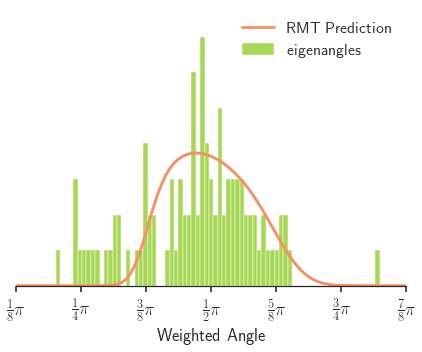

In [168]:
from matplotlib import mlab
sns.set(context='poster', style='ticks', palette='Set2')
fig, ax = plt.subplots(figsize=(7,5))

ax.set_xticks(np.array([0, 0.125, .25, .375, .5, .625, .75, .875, 1]) * np.pi)
ax.set_xticklabels(['0', r'$\frac{1}{8}\pi$', r'$\frac{1}{4}\pi$',
                    r'$\frac{3}{8}\pi$', r'$\frac{1}{2}\pi$',
                    r'$\frac{5}{8}\pi$', r'$\frac{3}{4}\pi$',
                    r'$\frac{7}{8}\pi$', r'$\pi$'], fontsize=18)

ax.set_xlabel(r'Weighted Angle$')

edges = np.linspace(0, np.pi, 120)
hist, _ = np.histogram(sample_angles, bins=edges, density=True)

if all_to_all:
    label = [r'$w_{ij}\cdot\angle (\mathbf{v}_i,\mathbf{w}_j):$', '$\mathbf{v}_i,\mathbf{w}_j \in R^{100}$']
else:
    label = [r'$w_{ii}\cdot\angle (\mathbf{v}_i,\mathbf{w}_i):$', '$\mathbf{v}_i,\mathbf{w}_i \in R^{100}$']
ax.bar(edges[:-1], hist, np.diff(edges)[0] * .99,
       color=sns.color_palette('Set2')[4], edgecolor='w',
       label='eigenangles')
#        label='{}'.format(label[0]))
# ax.bar([0],[0], width=0, color='w', edgecolor='w', 
#        label='{}'.format(label[1]))

x = np.linspace(0, np.pi, 120)
y = scores.weighted_angle.weighted_angle_distribution(x, size, B=5000, use_gaus=all_to_all)
norm = np.sum(y) * (x[1] - x[0])
ax.plot(x, np.array(y) / norm, color=sns.color_palette('Set2')[1], label='RMT Prediction')

ax.set_xlim((0.125*np.pi,0.875*np.pi))
ax.set_yticks([])
plt.legend()

sns.despine(left=True)
plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/weighted_angle_example{}{}.pdf'
            .format('_all_to_all' if all_to_all else '', corr_method), 
            bbox_inches='tight')

plt.show()

0.244211468179
0.436934474259


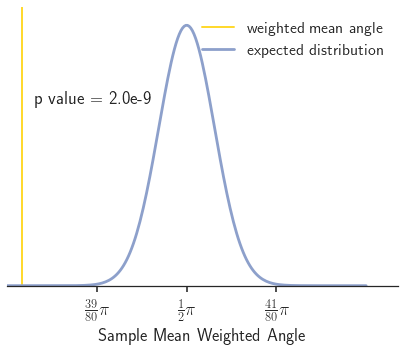

In [179]:
import matplotlib.mlab as mlab
from scipy.integrate import quad

x = np.linspace(0, np.pi, 120)
y = scores.weighted_angle.weighted_angle_distribution(x, size, B=5000, use_gaus=all_to_all)
norm = np.sum(y) * (x[1] - x[0])
y = y / norm
sample_std = np.std(inverse_transform_sampling(x,y,n_samples=10**6))
print sample_std
print np.std(sample_angles)

sns.set(context='poster', style='ticks', palette='Set2')
fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel(r'Sample Mean Weighted Angle')
#               + r'$^{}$'.format('{' + str(size) + '}'), fontsize=20)

ax.axvline(np.mean(sample_angles), color=sns.color_palette('Set2')[5], 
           lw=2, label='weighted mean angle')

if all_to_all:
    angle_nbr = size**2
else:
    angle_nbr = size

mu = np.pi/2.
sample_factor = 2.* np.sqrt(angle_nbr)
sigma = sample_std/sample_factor
x = np.linspace(np.pi/2-np.pi/(2.*sample_factor), np.pi/2.+np.pi/(2.*sample_factor), 220)
ax.plot(x,mlab.normpdf(x, mu, sigma), color=sns.color_palette('Set2')[2], 
        label=r'expected distribution')

p_integral = quad(mlab.normpdf, 0., np.mean(sample_angles), args=(mu,sigma))

if all_to_all:
    ax.set_xticks(np.array([0.49875, .5, .50125]) * np.pi)
    ax.set_xticklabels([r'$\frac{399}{800}\pi$', r'$\frac{1}{2}\pi$',
                        r'$\frac{401}{800}\pi$'], fontsize=18)
    ax.set_xlim((np.pi/2.-np.pi/610., np.pi/2.+np.pi/500.))
else:
    ax.set_xticks(np.array([0.4875, .5, .5125]) * np.pi)
    ax.set_xticklabels([r'$\frac{39}{80}\pi$', r'$\frac{1}{2}\pi$',
                        r'$\frac{41}{80}\pi$'], fontsize=18)
    ax.set_xlim((np.pi/2.-np.pi/40., np.pi/2.+np.pi/34.))

ax.text(.07, .65, 'p value = ' + '{}'.format(to_precision(p_integral[0],2)), 
        fontsize=18, transform=ax.transAxes)

ax.set_yticks([])
ax.set_yticklabels([''])

plt.legend()
sns.despine(left=True)

plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/mean_weighted_angle_example{}{}.pdf'
            .format('_all_to_all' if all_to_all else '',corr_method), 
            bbox_inches='tight')
plt.show()

## Parameter Scan

In [4]:
class angle_test(tests.correlation_matrix_test, tests.model2model_test):
    score_type = scores.weighted_angle
    params = {'all_to_all': True,
              'two_sided': False,
              'alpha': 0.0001,
              'binsize': 2*ms,
              'bin_num': 5000}

    def compute_score(self, prediction1, prediction2):
        score = self.score_type.compute(prediction1, prediction2, **self.params)
        return score

size = 100
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms
B = int(tstop/binsize)
angle_score = [0] * 99
count = 0

In [44]:
start_time = time()
for A in [[2],[3],[4],[5],[6],[7],[8],[9],[10]]:
    for cc in [0,.1,.2,.3,.4,.5,.6,.7,.8,.9, 1.]:
        temp_p = np.zeros(10)
        for repeat in range(10):
            model_A = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                                correlation_method='pairwise_equivalent', t_start=tstart, t_stop=tstop,
                                                shuffle=False, name='A')
            model_B = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                                correlation_method='pairwise_equivalent', t_start=tstart, t_stop=tstop,
                                                shuffle=False, name='B')
            test = angle_test(model_A)
            score = test.judge(model_B)
            temp_p[repeat] = score.pvalue
        
        m, s = divmod(time() - start_time, 60)
        h, m = divmod(m, 60)
        print 'time %d:%02d:%02d' % (h, m, s)
        angle_score[count] = (np.mean(temp_p), np.std(temp_p))
        print 'A: ', A, ' cc: ', cc
        print angle_score[count]
        count = count + 1

time 0:00:55
A:  [2]  cc:  0
(0.37084114029300858, 0.22651928999179627)
time 0:01:57
A:  [2]  cc:  0.1
(0.33535069622367686, 0.29209039916327617)
time 0:03:00
A:  [2]  cc:  0.2
(0.24380629980583302, 0.22662866931109452)
time 0:04:05
A:  [2]  cc:  0.3
(0.29244059540586853, 0.31733151770085399)
time 0:05:04
A:  [2]  cc:  0.4
(0.27247494598679312, 0.33308970068214133)
time 0:06:28
A:  [2]  cc:  0.5
(0.19784950047123839, 0.21512012476049705)
time 0:07:26
A:  [2]  cc:  0.6
(0.27376556500512805, 0.30159511503478459)
time 0:08:36
A:  [2]  cc:  0.7
(0.27515668812632821, 0.29611626079689779)
time 0:09:41
A:  [2]  cc:  0.8
(0.29559426056588967, 0.30773890961604516)
time 0:10:53
A:  [2]  cc:  0.9
(0.34963443124205773, 0.30411425061105019)
time 0:12:11
A:  [2]  cc:  1.0
(0.043526307136489847, 0.084802384711492693)
time 0:13:24
A:  [3]  cc:  0
(0.19587223398440451, 0.2351713098707684)
time 0:14:36
A:  [3]  cc:  0.1
(0.26147217778196574, 0.2788941099326373)
time 0:15:48
A:  [3]  cc:  0.2
(0.14823885

IndexError: list assignment index out of range

In [34]:
one2one_score = [(0.36515108544895669, 0.28519844429758318), (0.54851045870369353, 0.19426935172973189), (0.28955918402263697, 0.24965900911881378), (0.20659746499782389, 0.18571213424690639), (0.2093053646792625, 0.19809888606313794), (0.16558865538712753, 0.16668339047506317), (0.048605253183279566, 0.059185156814437596), (0.10622474834209691, 0.09156661699216842), (0.036966298187457378, 0.033407336905126567), (0.056266895949757777, 0.078403751537883093), (0.05489286760284149, 0.096374430195681232), (0.46679844614964316, 0.18103610842774054), (0.26279907839379274, 0.25049959141414258), (0.23406046612979239, 0.20112436252391364), (0.084502295885681228, 0.11984985186485254), (0.065285403940612316, 0.078481227547690907), (0.043153165793153897, 0.095413821532174176), (0.025687228819599766, 0.019896301182271276), (0.026444073963876304, 0.03609217866541875), (0.00095306425235996744, 0.0015620441211451888), (0.021041828111060899, 0.038954341310934011), (0.003661544327515811, 0.0063606871117332861), (0.44355219611150476, 0.22837589787780316), (0.20488144062694952, 0.17453188786032314), (0.08373963902244605, 0.13451614200634276), (0.071373992127979541, 0.095985891241064158), (0.040769824624453228, 0.089702455358021044), (0.020097236224841414, 0.023517273640683126), (0.014794124350868011, 0.039410059633892471), (0.0035059936611995558, 0.006302832357958631), (0.00019320372894441522, 0.00044020473196513258), (0.0002481314605785599, 0.00052085951278819844), (3.6623285738402176e-06, 7.0220947611440863e-06), (0.45145402155204895, 0.18360895179616266), (0.23696831022570147, 0.22198434369035783), (0.044715631972535738, 0.033240949826012847), (0.005769743608754656, 0.013513467661680319), (0.017505536208282237, 0.034969445682963667), (0.00031222441224207961, 0.00062677370553817472), (0.002051925086684574, 0.003290047819327496), (1.8248785916989659e-05, 2.8188504361216401e-05), (4.6084529097752749e-07, 1.1697415004732661e-06), (3.1756549339651981e-06, 9.3862899358057238e-06), (1.4902631062512531e-05, 3.9592737507868432e-05), (0.24299756396713718, 0.22028677558249574), (0.19911817216238817, 0.21187936184615624), (0.017638708825371729, 0.030146616598536187), (0.0041237299169513868, 0.0064961130503585242), (0.0068501555262390811, 0.015026786601720344), (9.5791780769181057e-05, 0.0001980563768792206), (0.00010004629057180624, 0.00026912133613257001), (2.3322371088060743e-05, 6.1239601295996014e-05), (3.1333997475597551e-07, 8.3153032858919189e-07), (1.3289595515593543e-08, 3.9083324532206832e-08), (3.2978364887089639e-09, 6.8190796263430161e-09), (0.4295958792125491, 0.26201814790803357), (0.032069466267977541, 0.037902484131968457), (0.028911384243815081, 0.065040634202643804), (0.030811041839389385, 0.08359998427700939), (0.00020851705627810882, 0.00037212953834935166), (0.0013396823050653664, 0.003811818307099766), (8.4985736872138286e-07, 1.6999954162644015e-06), (4.1260447464124272e-08, 8.4490181690367023e-08), (1.4853838536435657e-09, 4.392528757398207e-09), (2.0153971451997381e-12, 5.2890641030473815e-12), (1.3744785969063278e-14, 3.9965074026708321e-14), (0.45900690482787931, 0.26402658369321647), (0.071318686483454186, 0.064058745259429117), (0.028954466000576301, 0.040065844490287036), (0.01007802454086934, 0.028007199937047249), (4.6161612341970445e-05, 8.6779413694794015e-05), (3.1315091937338162e-06, 5.3964851125759851e-06), (2.3057750762405419e-08, 6.9117363262631541e-08), (6.801492775314335e-12, 1.0843345830113934e-11), (1.3706239069226448e-12, 3.4559409715840584e-12), (4.1207188724988749e-17, 8.8685339383580175e-17), (4.853971118887452e-16, 1.4550663155272814e-15), (0.4700868080780024, 0.31882113367661108), (0.098133341108626509, 0.15974699293398237), (0.015391247383854062, 0.030445572144765908), (0.0004255475615160675, 0.00068637353938486869), (0.00013848208133573651, 0.000411764647167285), (1.0570425539775466e-07, 3.0620507549337193e-07), (1.0166977531249121e-10, 2.5254935595514617e-10), (7.9716212365575135e-13, 2.327129989545154e-12), (4.4872667477223186e-15, 1.2693171441072557e-14), (1.7901076399203362e-18, 5.1068855108321136e-18), (1.0440193076943879e-22, 3.0451215327859924e-22), (0.38650947839813921, 0.25838870319512608), (0.024095597744015689, 0.019046922059578385), (0.0012280653212727579, 0.0014788749296959153), (0.00013499430182739694, 0.00032030897978974787), (3.7207965315509178e-07, 4.102973726550522e-07), (4.5827758756764819e-08, 1.3255635022140042e-07), (3.3957776083817579e-12, 1.0015537446312929e-11), (1.1056137706152651e-16, 3.2993096126671359e-16), (2.2782011820940788e-18, 5.9163353613637567e-18), (4.6539545146785105e-23, 1.3961845045108647e-22), (5.2193969510188503e-28, 1.5619942113130131e-27)]
all2all_score = [(0.30458231544939157, 0.22763303989467845), (0.31445619892449678, 0.20688855412071028), (0.37366537116943099, 0.30266804689396287), (0.30089669715372797, 0.22967603731919442), (0.35525082555784993, 0.24288105684614031), (0.20986743372617758, 0.16149348318859974), (0.33601721387496508, 0.29133392731103402), (0.13368503042162794, 0.13646104263339001), (0.18539048083356899, 0.25098744131919865), (0.1764892557514135, 0.19037820182712806), (0.18914592573283173, 0.21459960959287008), (0.27754555184280022, 0.27820719720913306), (0.40834898906250949, 0.31594026811077786), (0.3661204016225863, 0.33100849854107534), (0.175728257284089, 0.19198648666555471), (0.20941166095566666, 0.19842834058330161), (0.12353767214637083, 0.17550447856993373), (0.16534906554730172, 0.1675659465091292), (0.082907559299409878, 0.10928285822435915), (0.093904566787588656, 0.1530522528174964), (0.099220811285352317, 0.095911395816081782), (0.16432039492579473, 0.1328059100908224), (0.21863488311854579, 0.26324422242420498), (0.25500407000998465, 0.29364293834784383), (0.2034591931442648, 0.26922549116711414), (0.21002548310297436, 0.20350246486554244), (0.30826688509496403, 0.3056595396664869), (0.19171483731670219, 0.19044988716908504), (0.15663455053391478, 0.16152078288377922), (0.21055843282350031, 0.23636518217444769), (0.24111018779047416, 0.25742404902036858), (0.14614012050502984, 0.18306177340116125), (0.14343445211076256, 0.21752361145774171), (0.18295134346042988, 0.16976541779219984), (0.34154394052816839, 0.31104463323896009), (0.1736345368991572, 0.21897788845627794), (0.14790237227236996, 0.12271454949523436), (0.19487817618842002, 0.24047619520829441), (0.20953445505612484, 0.2593077072458248), (0.23552178842697588, 0.19999223672730512), (0.078473379681822553, 0.098274533458974966), (0.14473780376404757, 0.10477997708598845), (0.16892966268999404, 0.18521201200597201), (0.18723040311011796, 0.23216521628904266), (0.26699927593442185, 0.23879845764369714), (0.12361769168489305, 0.16681396106666577), (0.1268573846645436, 0.11404439711489575), (0.21702005176047598, 0.23440056115635244), (0.13391454607522973, 0.17632745103403846), (0.14985089678507596, 0.14648105265793923), (0.18050181587521485, 0.23158407053006208), (0.073183374330286863, 0.073664262175896791), (0.12480149685124146, 0.18854860857104652), (0.14230942585353087, 0.20987245422901196), (0.1329951251179447, 0.20180832491804399), (0.26486612078483424, 0.27328794906919007), (0.45724589449795, 0.32426437173994099), (0.34718264926969084, 0.23080256757059273), (0.20266544742124654, 0.1812588763282498), (0.15435013766913602, 0.1415054098402615), (0.17207536138480981, 0.18856123431242994), (0.089130846924354967, 0.11505619269869193), (0.12530966114431971, 0.10444549152642348), (0.1205235542645066, 0.16954225865564945), (0.096448775323415392, 0.10476838074692368), (0.070577429336992001, 0.066584981373594379), (0.25601928805545693, 0.21358721013349713), (0.10528856904182497, 0.0662638014618359), (0.24853423673909644, 0.30172825164919354), (0.29419940307533909, 0.30112481253129081), (0.11360085169613957, 0.11884770385608073), (0.16167813085455945, 0.27026623707470399), (0.22377221282530541, 0.19102061919719832), (0.10773559321670594, 0.21667213477596498), (0.063289569420236225, 0.075564552268822416), (0.10093801397334937, 0.17403118202251777), (0.079042976173621368, 0.12812198965514468), (0.26015835504348811, 0.23546706962089084), (0.30837559556872113, 0.29062111623029124), (0.24350795798137467, 0.29091399439097143), (0.26405559083213659, 0.23594669764553541), (0.13245605191766521, 0.17287191283027492), (0.19252790381013812, 0.199179493099264), (0.16899800558126882, 0.16135983865102932), (0.022078860623594054, 0.030241175638940049), (0.20119022549279575, 0.18592772640254218), (0.10558508180049739, 0.13179948254747528), (0.057184121979680272, 0.08697401329974358), (0.24744219647245461, 0.27025494298512631), (0.18746133389370848, 0.20322337215618394), (0.1993647370301336, 0.22066887895545836), (0.35833163336889612, 0.27194662942241865), (0.085124854673520461, 0.11604841925309951), (0.10372177746460139, 0.13423302285807015), (0.078554535130518521, 0.092088353327829053), (0.055913208174448926, 0.083660312771253506), (0.13739720912417228, 0.14480581999957859), (0.033202406678519619, 0.049993385595991771), (0.11919904729765363, 0.1661337624163598)]

ValueError: x and y must have same first dimension

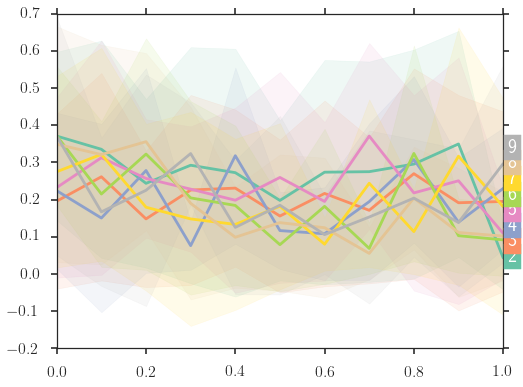

In [7]:
sns.set(palette=sns.color_palette("Set2", 8)+[(0.4,0.4,0.4)], style='ticks', context='poster')
fig, ax = plt.subplots(figsize=(8,6))
rho = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.]
pvalues = [a[0] for a in angle_score]
std_min = [a[0]-a[1] for a in angle_score]
std_max = [a[0]+a[1] for a in angle_score]

for count, A in enumerate([2,3,4,5,6,7,8,9,10]):
    curr_handle, = ax.plot(rho, pvalues[count*11:count*11+11])
    ax.fill_between(rho, std_min[count*11:count*11+11], 
                    std_max[count*11:count*11+11], color=curr_handle.get_color(), 
                    alpha=0.1)
    ax.text(1.01, .42/10.*A-.05,
                        '{}'.format(A),
                        fontweight='bold',
                        backgroundcolor=curr_handle.get_color(),
                        color='w')

ax.set_xlabel(r'$\rho$')
ax.set_ylabel('p value')
ax.set_ylim((0,.55))
ax.grid()
sns.despine()
# plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/weighted_angle_param_scan_all_to_all.png', bbox_inches='tight')

In [3]:
from pypet import Trajectory
import numpy as np
from os import listdir
from os.path import expanduser
from h5py import File
from time import time
import seaborn as sns
import matplotlib.pyplot as plt

data_path = '/home/robin/Projects/pop_cch_results/'
filename = '9A_13rho_result.h5'

traj = Trajectory(filename=data_path + filename)
traj.f_load(index=-1, load_parameters=0,
            load_results=2, force=True)
traj.v_auto_load = True

assembly_sizes = [[2], [3], [4], [5], [6], [7], [8], [9], [10]]
correlations = [.0, .05, .1, .15, .2, .3, .4, .5, .6, .7, .8, .9, 1.]

cpp_cpp_o2o = np.zeros((len(assembly_sizes),len(correlations),2))
cpp_cpp_a2a = np.zeros((len(assembly_sizes),len(correlations),2))

pwc_pwc_o2o = np.zeros((len(assembly_sizes),len(correlations),2))
pwc_pwc_a2a = np.zeros((len(assembly_sizes),len(correlations),2))

cpp_pwc_o2o = np.zeros((len(assembly_sizes),len(correlations),2))
cpp_pwc_a2a = np.zeros((len(assembly_sizes),len(correlations),2))

for A_count, A in enumerate(assembly_sizes):
    for cc_count, cc in enumerate(correlations):
        run_count = A_count * len(correlations) + cc_count
        run = traj.results['run_{:08d}'.format(run_count)]

        cpp_cpp_o2o[A_count][cc_count][0] = run['cpp_cpp_o2o_mean']
        cpp_cpp_o2o[A_count][cc_count][1] = run['cpp_cpp_o2o_std']
        cpp_cpp_a2a[A_count][cc_count][0] = run['cpp_cpp_a2a_mean']
        cpp_cpp_a2a[A_count][cc_count][1] = run['cpp_cpp_a2a_std']

        pwc_pwc_o2o[A_count][cc_count][0] = run['pwc_pwc_o2o_mean']
        pwc_pwc_o2o[A_count][cc_count][1] = run['pwc_pwc_o2o_std']
        pwc_pwc_a2a[A_count][cc_count][0] = run['pwc_pwc_a2a_mean']
        pwc_pwc_a2a[A_count][cc_count][1] = run['pwc_pwc_a2a_std']

        cpp_pwc_o2o[A_count][cc_count][0] = run['cpp_pwc_o2o_mean']
        cpp_pwc_o2o[A_count][cc_count][1] = run['cpp_pwc_o2o_std']
        cpp_pwc_a2a[A_count][cc_count][0] = run['cpp_pwc_a2a_mean']
        cpp_pwc_a2a[A_count][cc_count][1] = run['cpp_pwc_a2a_std']

No handlers could be found for logger "pypet.storageservice.HDF5StorageService"


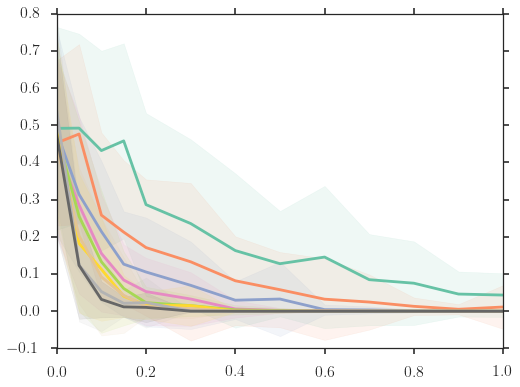

In [4]:
sns.set(palette=sns.color_palette("Set2", 8) + [(0.4, 0.4, 0.4)],
        style='ticks', context='poster')
fig, ax = plt.subplots(figsize=(8, 6))
for A_count, A in enumerate(assembly_sizes):
    curr_handle, = ax.plot(correlations, cpp_cpp_o2o[A_count,:,0])
    ax.fill_between(correlations,
                    cpp_cpp_o2o[A_count,:,0]-cpp_cpp_o2o[A_count,:,1],
                    cpp_cpp_o2o[A_count,:,0]+cpp_cpp_o2o[A_count,:,1],
                    color=curr_handle.get_color(),
                    alpha=0.1)
plt.show()

In [5]:
data_path = '/home/robin/Projects/pop_cch_results/'
filename = '10A_10A_fixcc02_result.h5'

traj = Trajectory(filename=data_path + filename)
traj.f_load(index=-1, load_parameters=0,
            load_results=2, force=True)
traj.v_auto_load = True

assembly_sizes = [[], [2], [3], [4], [5], [6], [7], [8], [9], [10]]

cpp_cpp_fix_cc_02 = np.zeros((len(assembly_sizes),len(assembly_sizes),2))

for A1_count, A1 in enumerate(assembly_sizes):
    for A2_count, A2 in enumerate(assembly_sizes):
        run_count = A1_count * len(assembly_sizes) + A2_count
        run = traj.results['run_{:08d}'.format(run_count)]

        cpp_cpp_fix_cc_02[A1_count][A2_count][0] = run['cpp_cpp_o2o_mean']
        cpp_cpp_fix_cc_02[A1_count][A2_count][1] = run['cpp_cpp_o2o_std']

ValueError: File `/home/robin/Projects/pop_cch_results/10A_10A_fixcc02_result.h5` does not exist.

In [9]:
data_path = '/home/robin/Projects/pop_cch_results/'
filename = '11cc_11cc_fixA5_result.h5'

correlations = [.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.]

traj = Trajectory(filename=data_path + filename)
traj.f_load(index=-1, load_parameters=0,
            load_results=2, force=True)
traj.v_auto_load = True

cpp_cpp_fix_A_5 = np.zeros((len(correlations),len(correlations),2))

for cc1_count, cc1 in enumerate(correlations):
    for cc2_count, cc2 in enumerate(correlations):
        run_count = cc1_count * len(correlations) + cc2_count
        run = traj.results['run_{:08d}'.format(run_count)]

        cpp_cpp_fix_A_5[cc1_count][cc2_count][0] = run['cpp_cpp_o2o_mean']
        cpp_cpp_fix_A_5[cc1_count][cc2_count][1] = run['cpp_cpp_o2o_std']

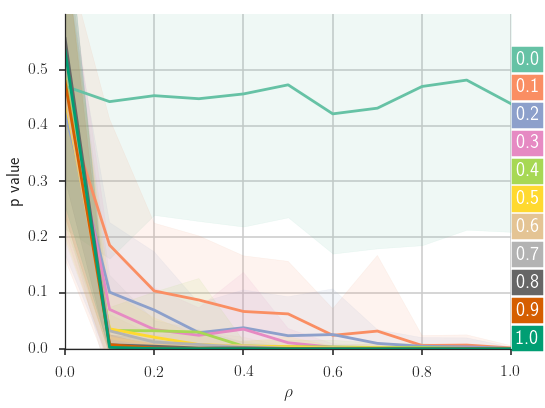

In [35]:
sns.set(palette=sns.color_palette("Set2", 8)+[(0.4,0.4,0.4)]+['r','g'], style='ticks', context='poster')
fig, ax = plt.subplots(figsize=(8,6))

for count, cc in enumerate(correlations):
    curr_handle, = ax.plot(correlations, cpp_cpp_fix_A_5[count,:,0])
    ax.fill_between(correlations, cpp_cpp_fix_A_5[count,:,0]-cpp_cpp_fix_A_5[count,:,1], 
                    cpp_cpp_fix_A_5[count,:,0]+cpp_cpp_fix_A_5[count,:,1], color=curr_handle.get_color(), 
                    alpha=0.1)
    ax.text(1.01, .51-.5/10.*count,
                        '{}'.format(cc),
                        fontweight='bold',
                        backgroundcolor=curr_handle.get_color(),
                        color='w')

ax.set_xlabel(r'$\rho$')
ax.set_ylabel('p value')
ax.set_ylim((0.00,.6))
# ax.set_yscale('log')
ax.grid()
sns.despine()
plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/eigenangle_param_scan_o2o_fixA5.png', bbox_inches='tight')